In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)
#datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
datagen=ImageDataGenerator(validation_split=0.25)

label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    elif traindf['seborrheic_keratosis'][i] == '1.0':
        label[i]='2'
    else:
        label[i]='0'

traindf['label']=label    

#create a label
label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    elif testdf['seborrheic_keratosis'][i] == '1.0':
        label[i]='2'
    else:
        label[i]='0'

testdf['label']=label

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            subset='training',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=(32,32)
                                           )

valid_generator=datagen.flow_from_dataframe(dataframe=traindf,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            subset='validation',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=(32,32)
                                           )

#test_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(32,32)
                                               )



Found 1500 validated image filenames belonging to 3 classes.
Found 500 validated image filenames belonging to 3 classes.
Found 600 validated image filenames.


In [2]:
IMG_SIZE = 224
from tensorflow.keras.applications import EfficientNetB0
# Create the base model from the pre-trained model EfficientNet
base_model = EfficientNetB0(include_top=False, weights="imagenet")

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

NUM_CLASSES=3
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [4]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit(train_generator,
          epochs=10,
          validation_data=valid_generator,
          verbose=1
         )

Epoch 1/10
47/47 [==============================] - 314s 7s/step - loss: 1.5908 - accuracy: 0.5410 - val_loss: 0.9944 - val_accuracy: 0.7420
Epoch 2/10
47/47 [==============================] - 300s 6s/step - loss: 1.2723 - accuracy: 0.6179 - val_loss: 0.6824 - val_accuracy: 0.7440
Epoch 3/10
47/47 [==============================] - 294s 6s/step - loss: 1.0319 - accuracy: 0.6848 - val_loss: 0.6785 - val_accuracy: 0.7280
Epoch 4/10
47/47 [==============================] - 297s 6s/step - loss: 1.1181 - accuracy: 0.6587 - val_loss: 0.6413 - val_accuracy: 0.7420
Epoch 5/10
47/47 [==============================] - 294s 6s/step - loss: 1.0797 - accuracy: 0.6680 - val_loss: 0.7935 - val_accuracy: 0.7440
Epoch 6/10
47/47 [==============================] - 291s 6s/step - loss: 0.9110 - accuracy: 0.6952 - val_loss: 0.7642 - val_accuracy: 0.7340
Epoch 7/10
47/47 [==============================] - 290s 6s/step - loss: 0.9973 - accuracy: 0.6915 - val_loss: 0.8171 - val_accuracy: 0.7160
Epoch 8/10
47

In [5]:
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

15/15 [==============================] - 19s 1s/step - loss: 0.7943 - accuracy: 0.7312


[0.7943381667137146, 0.731249988079071]

In [6]:
test_generator.reset()
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

18/18 [==============================] - 252s 14s/step


In [7]:
predicted_class_indices=np.argmax(pred,axis=1)

In [8]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

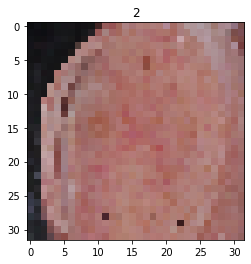

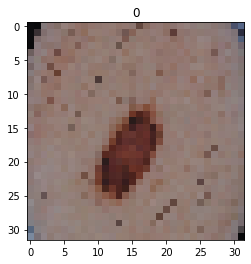

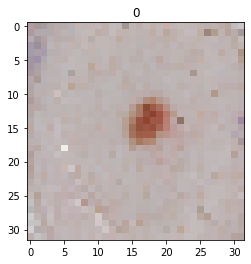

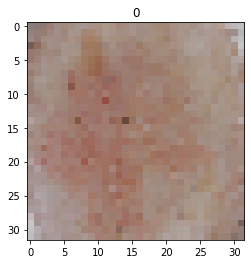

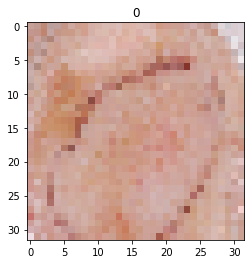

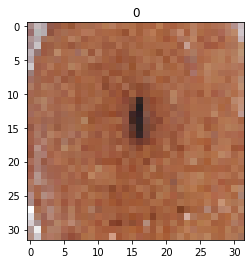

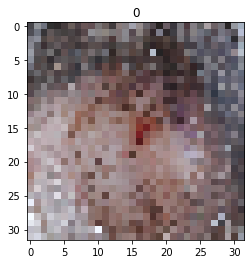

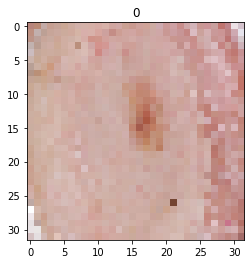

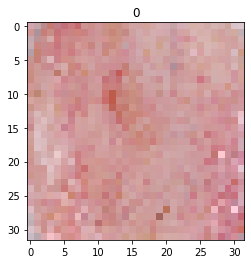

In [9]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(9):
    image = x[i]
    plt.title(predictions[i])
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [17]:
print('Predictions')
print('Melanoma:' + str(np.count_nonzero(predicted_class_indices == 1)))
print('Seborrheic Keratosis:' + str(np.count_nonzero(predicted_class_indices == 2)))
print('Non-Melanoma:' + str(np.count_nonzero(predicted_class_indices == 0)))

print('\nGround Truth')
print('Melanoma:' + str(np.count_nonzero(testdf['label'] == '1')))
print('Seborrheic Keratosis:' + str(np.count_nonzero(testdf['label'] == '2')))
print('Non-Melanoma:' + str(np.count_nonzero(testdf['label'] == '0')))

Predictions
Melanoma:21
Seborrheic Keratosis:49
Non-Melanoma:506

Ground Truth
Melanoma:117
Seborrheic Keratosis:90
Non-Melanoma:393


In [16]:
testdf

,image_id,melanoma,seborrheic_keratosis,label
0,ISIC_0012086.jpg,0.0,1.0,2
1,ISIC_0012092.jpg,0.0,0.0,0
2,ISIC_0012095.jpg,0.0,0.0,0
3,ISIC_0012134.jpg,0.0,1.0,2
4,ISIC_0012136.jpg,0.0,1.0,2
...,...,...,...,...
595,ISIC_0016068.jpg,0.0,0.0,0
596,ISIC_0016069.jpg,0.0,0.0,0
597,ISIC_0016070.jpg,0.0,0.0,0
598,ISIC_0016071.jpg,0.0,0.0,0
